# Autoencoders

> Final project as a Deep Learning for Computer Vision class requirement &#128187;

Jesús E. Hermosilla D.

### Contents

0. Introduction
1. Hyperparameter Search
2. Deep Autoencoders
3. Sparse Autoencoders
4. Denoising Autoencoders
5. Anomaly Detection

## Introduction

Autoencoders (AEs) were first proposed by Rumelhart in 1986. These neural networks are specifically built to learn representations of input data and accurately reconstruct it. AEs work by compressing the input into a concise, meaningful representation and then decoding it to recreate the original data. Classical AEs generally comprises an input layer, a single hidden layers, and an output layer; however, this is not a requirement. In other hand, stacked AEs (or deep AEs), contains multiple hidden layers.

<center>
<img width="278" height="292" src="images/structure.png"/>
</center> 

### References

- Berahmand, K., Daneshfar, F., Salehi, E. S., Li, Y., & Xu, Y. (2024). Autoencoders and their applications in machine learning: a survey. Artificial Intelligence Review, 57(2), 28.
- Boehmke, B., & Greenwell, B. M. (2019). Hands-on machine learning with R. Chapman and Hall/CRC.
- Rumelhart, D. E., Hinton, G. E., & Williams, R. J. (1986). Learning representations by back-propagating errors. nature, 323(6088), 533-536.

In [8]:
"""
Libraries
"""

import time
import torch
import torch.nn as nn
import skorch
from skorch import NeuralNetRegressor
from sklearn.model_selection import GridSearchCV
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from scipy.special import kl_div
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
styles = [dict(selector="caption", props=[("text-align", "center"), ("font-size", "150%"), ("color", 'black')])]

In [9]:
"""
Hyperparameters
"""

learning_rate_   = 0.001
batch_size_      = 64
num_epochs_      = 15
input_dimension_ = 32*32*3
laten_dimension_ = 256
encoder_neurons_ = 1024
decoder_neurons_ = 256

if torch.cuda.is_available():
    dev = "cuda:0"
else:
    dev = "cpu"

In [10]:
"""
Loading datasets
"""

# Cifar 10
train_set = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.Compose([transforms.ToTensor()]))
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size_, shuffle=True)
features = torch.stack([train_set[i][0].view(-1) for i in range(len(train_set))]).numpy()
targets = features

test_set = datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.Compose([transforms.ToTensor()]))
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size_, shuffle=True)

# Cifar 100
train_set2 = datasets.CIFAR100(root='./data', train=True, download=True, transform=transforms.Compose([transforms.ToTensor()]))
train_loader2 = torch.utils.data.DataLoader(train_set2, batch_size=batch_size_, shuffle=True)
features2 = torch.stack([train_set2[i][0].view(-1) for i in range(len(train_set2))]).numpy()
targets2 = features2

test_set2 = datasets.CIFAR100(root='./data', train=False, download=True, transform=transforms.Compose([transforms.ToTensor()]))
test_loader2 = torch.utils.data.DataLoader(test_set, batch_size=batch_size_, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


## Architecture

In [11]:
"""
    Args:
        input_dim (int): The size of the input data (height*width*channels).
        latent_dim (int): The size of the latent space.
        encoder_neurons (int): Number of neurons in the first encoder layer.
        decoder_neurons (int): Number of neurons in the first decoder layer.
"""

class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim, encoder_neurons, decoder_neurons):
        super(Autoencoder, self).__init__()
        # Encoder: Compresses image to a latent representation
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, encoder_neurons),
            nn.ReLU(),
            nn.Linear(encoder_neurons, decoder_neurons),
            nn.ReLU(),
            nn.Linear(decoder_neurons, latent_dim),
            nn.ReLU(),
        )
        # Decoder: Reconstructs image from the latent representation
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, decoder_neurons),
            nn.ReLU(),
            nn.Linear(decoder_neurons, encoder_neurons),
            nn.ReLU(),
            nn.Linear(encoder_neurons, input_dim),
            nn.Sigmoid())

    def forward(self, x):
        x = x.view(x.size(0), -1)
        # Pass through encoder
        latent = self.encoder(x)
        self.latent_ = latent
        # Pass through decoder
        reconstructed = self.decoder(latent)
        return reconstructed

## 1. Hyperparameter Search

In [12]:
"""
Creating model container
"""

# Cifar 10
earlystopping = skorch.callbacks.EarlyStopping(monitor = 'train_loss', lower_is_better = False, patience = 10)
AutoencoderModel = NeuralNetRegressor(module=Autoencoder,
                                      module__input_dim=32 * 32 * 3, 
                                      callbacks = [earlystopping],
                                      criterion=nn.MSELoss,
                                      train_split=None,
                                      max_epochs=15,                                        
                                      batch_size=64,
                                      device=dev,
                                      lr=0.001)

# Cifar 100
earlystopping2 = skorch.callbacks.EarlyStopping(monitor = 'train_loss', lower_is_better = False, patience = 10)
AutoencoderModel2 = NeuralNetRegressor(module=Autoencoder,
                                      module__input_dim=32 * 32 * 3, 
                                      callbacks = [earlystopping2],
                                      criterion=nn.MSELoss,
                                      train_split=None,
                                      max_epochs=15,                                        
                                      batch_size=64,
                                      device=dev,
                                      lr=0.001)

In [13]:
"""
Applying hyperparameter grid search
"""

GridModel = {'module__encoder_neurons': [1024, 512],
             'module__decoder_neurons': [512, 256],
             'module__latent_dim':      [256, 128],
             'lr':                      [0.001, 0.01]}

# Cifar 10
grid_search = GridSearchCV(AutoencoderModel,
                           param_grid=GridModel,
                           scoring='neg_mean_squared_error',
                           refit=True,
                           n_jobs=2,
                           cv=2,                             
                           verbose=1)

# Cifar 100
grid_search2 = GridSearchCV(AutoencoderModel2,
                           param_grid=GridModel,
                           scoring='neg_mean_squared_error',
                           refit=True,
                           n_jobs=2,
                           cv=2,                             
                           verbose=1)

In [14]:
# Cifar 10
start_time = time.time()
grid_result = grid_search.fit(features, targets)
print("%s seconds" % (time.time() - start_time))

Fitting 2 folds for each of 16 candidates, totalling 32 fits


/home/jhermosilla/.local/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/jhermosilla/.local/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/jhermosilla/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (
/home/jhermosilla/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (
/home/jhermosilla/.loc

  epoch    train_loss     dur
-------  ------------  ------
      1        0.0643  2.3183
  epoch    train_loss     dur
-------  ------------  ------
      1        0.0638  2.3336
      2        0.0643  2.1335
      2        0.0638  2.1251
      3        0.0643  2.1004
      3        0.0638  2.1004
      4        0.0643  2.0997
      4        0.0638  2.0997
      5        0.0643  2.0999
      5        0.0638  2.0991
      6        0.0643  2.1020
      6        0.0638  2.1014
      7        0.0643  2.1082
      7        0.0638  2.1086
      8        0.0643  2.1064
      8        0.0638  2.1060
      9        0.0643  2.1092
      9        0.0638  2.1108
     10        0.0643  2.1108
     10        0.0638  2.1115


/home/jhermosilla/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)
/home/jherm

Stopping since train_loss has not improved in the last 10 epochs.
  epoch    train_loss     dur
-------  ------------  ------
      1        0.0638  2.0535
Stopping since train_loss has not improved in the last 10 epochs.
  epoch    train_loss     dur
-------  ------------  ------
      1        0.0643  2.0768
      2        0.0638  2.0812
      2        0.0643  2.0797
      3        0.0638  2.0802
      3        0.0643  2.0809
      4        0.0638  2.0879
      4        0.0643  2.0879
      5        0.0638  2.0888
      5        0.0643  2.0877
      6        0.0638  2.0852
      6        0.0643  2.0850
      7        0.0638  2.0915
      7        0.0643  2.0912
      8        0.0638  2.0883
      8        0.0643  2.0890
      9        0.0638  2.0912
      9        0.0643  2.0910
     10        0.0638  2.0862
     10        0.0643  2.0862


/home/jhermosilla/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


Stopping since train_loss has not improved in the last 10 epochs.


/home/jhermosilla/.local/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/home/jhermosilla/.local/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/jhermosilla/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


Stopping since train_loss has not improved in the last 10 epochs.
  epoch    train_loss     dur
-------  ------------  ------
      1        0.0638  1.4728


/home/jhermosilla/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


      2        0.0638  1.5164
      3        0.0638  1.5418
  epoch    train_loss     dur
-------  ------------  ------
      1        0.0643  1.7053
      4        0.0638  1.5753
      2        0.0643  1.5743
      5        0.0638  1.5755
      3        0.0643  1.5707
      6        0.0638  1.5640
      4        0.0643  1.5676
      7        0.0638  1.5575
      5        0.0643  1.5674
      8        0.0638  1.3688
      6        0.0643  1.5791
      9        0.0638  1.3703
      7        0.0643  1.5852
     10        0.0638  1.4176
      8        0.0643  1.4477
      9        0.0643  1.4181


/home/jhermosilla/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


     10        0.0643  1.5367
Stopping since train_loss has not improved in the last 10 epochs.
  epoch    train_loss     dur
-------  ------------  ------
      1        0.0638  1.5597
      2        0.0638  1.5004


/home/jhermosilla/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


      3        0.0638  1.3433
Stopping since train_loss has not improved in the last 10 epochs.
  epoch    train_loss     dur
-------  ------------  ------
      1        0.0643  1.5606
      4        0.0638  1.5073
      2        0.0643  1.5344
      5        0.0638  1.5406
      3        0.0643  1.5355
      6        0.0638  1.5445
      4        0.0643  1.5401
      7        0.0638  1.5469
      8        0.0638  1.4258
      5        0.0643  1.5811
      9        0.0638  1.3355
      6        0.0643  1.5821
     10        0.0638  1.3325
      7        0.0643  1.5913
      8        0.0643  1.5592


/home/jhermosilla/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


      9        0.0643  1.6489
Stopping since train_loss has not improved in the last 10 epochs.
  epoch    train_loss     dur
-------  ------------  ------
      1        0.0638  1.6937
     10        0.0643  1.6760
      2        0.0638  1.6945
      3        0.0638  1.7217
Stopping since train_loss has not improved in the last 10 epochs.
      4        0.0638  1.6381


/home/jhermosilla/.local/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/jhermosilla/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (
/home/jhermosilla/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This l

      5        0.0638  1.5512
      6        0.0638  1.7860
  epoch    train_loss     dur
-------  ------------  ------
      1        0.0643  2.1061
      7        0.0638  1.9714
      2        0.0643  1.9704
      8        0.0638  1.9660
      3        0.0643  1.9654
      9        0.0638  1.9661
      4        0.0643  1.9673
     10        0.0638  1.9683
      5        0.0643  1.9671
      6        0.0643  1.9227


/home/jhermosilla/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


      7        0.0643  1.9262
Stopping since train_loss has not improved in the last 10 epochs.
  epoch    train_loss     dur
-------  ------------  ------
      1        0.0638  1.9573
      8        0.0643  1.9673
      2        0.0638  1.9640
      9        0.0643  1.9593
      3        0.0638  1.9564
     10        0.0643  1.9607
      4        0.0638  1.9593
      5        0.0638  1.9752


/home/jhermosilla/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


      6        0.0638  1.9279
Stopping since train_loss has not improved in the last 10 epochs.
  epoch    train_loss     dur
-------  ------------  ------
      1        0.0643  1.9490
      7        0.0638  1.9578
      2        0.0643  1.9654
      8        0.0638  1.9545
      3        0.0643  1.9626
      9        0.0638  1.9614
      4        0.0643  1.9720
     10        0.0638  1.9696
      5        0.0643  1.9736


/home/jhermosilla/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


      6        0.0643  1.8260
Stopping since train_loss has not improved in the last 10 epochs.
  epoch    train_loss     dur
-------  ------------  ------
      1        0.0638  1.4647
      7        0.0643  1.7804
      2        0.0638  1.4768
      8        0.0643  1.7649
      3        0.0638  1.6275
      9        0.0643  1.6824
      4        0.0638  1.5555
     10        0.0643  1.7590
      5        0.0638  1.5134
      6        0.0638  1.5286


/home/jhermosilla/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


      7        0.0638  1.5366
Stopping since train_loss has not improved in the last 10 epochs.
  epoch    train_loss     dur
-------  ------------  ------
      1        0.0643  1.5412
      8        0.0638  1.4184
      2        0.0643  1.5427
      9        0.0638  1.3661
      3        0.0643  1.5364
     10        0.0638  1.5405
      4        0.0643  1.5507
      5        0.0643  1.5279


/home/jhermosilla/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


      6        0.0643  1.5286
Stopping since train_loss has not improved in the last 10 epochs.
  epoch    train_loss     dur
-------  ------------  ------
      1        0.0638  1.3769
      2        0.0638  1.3408
      7        0.0643  1.5414
      3        0.0638  1.4839
      8        0.0643  1.5369
      4        0.0638  1.5366
      9        0.0643  1.5291
      5        0.0638  1.5302
     10        0.0643  1.5341
      6        0.0638  1.5302
Stopping since train_loss has not improved in the last 10 epochs.
      7        0.0638  1.5250


/home/jhermosilla/.local/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/jhermosilla/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


      8        0.0638  1.3075


/home/jhermosilla/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


      9        0.0638  1.5186
     10        0.0638  1.5261
  epoch    train_loss     dur
-------  ------------  ------
      1        0.0643  1.6805
      2        0.0643  1.5326


/home/jhermosilla/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


      3        0.0643  1.6434
Stopping since train_loss has not improved in the last 10 epochs.
  epoch    train_loss     dur
-------  ------------  ------
      1        0.0638  1.6860
      4        0.0643  1.7460
      2        0.0638  1.7803
      5        0.0643  1.7434
      3        0.0638  1.7084
      6        0.0643  1.7285
      4        0.0638  1.7533
      7        0.0643  1.7336
      5        0.0638  1.7176
      8        0.0643  1.7070
      6        0.0638  1.6951
      9        0.0643  1.7058
      7        0.0638  1.6891
     10        0.0643  1.6850
      8        0.0638  1.7998
      9        0.0638  1.7786


/home/jhermosilla/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


     10        0.0638  1.9876
Stopping since train_loss has not improved in the last 10 epochs.
  epoch    train_loss     dur
-------  ------------  ------
      1        0.0643  2.1279
      2        0.0643  2.0295


/home/jhermosilla/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


      3        0.0643  2.0445
Stopping since train_loss has not improved in the last 10 epochs.
  epoch    train_loss     dur
-------  ------------  ------
      1        0.0638  2.1090
      4        0.0643  2.1152
      2        0.0638  2.1194
      5        0.0643  2.1189
      3        0.0637  2.1123
      6        0.0643  2.1102
      4        0.0637  2.1115
      7        0.0643  2.1153
      5        0.0637  2.1134
      8        0.0643  2.1113
      6        0.0637  2.1128
      9        0.0643  2.1156
      7        0.0637  2.1165
     10        0.0643  2.1145
      8        0.0637  2.1203
      9        0.0637  2.0338
Stopping since train_loss has not improved in the last 10 epochs.
     10        0.0637  1.7724


/home/jhermosilla/.local/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/jhermosilla/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (
/home/jhermosilla/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This l

Stopping since train_loss has not improved in the last 10 epochs.


/home/jhermosilla/.local/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/jhermosilla/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


  epoch    train_loss     dur
-------  ------------  ------
      1        0.0643  1.8304


/home/jhermosilla/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


      2        0.0643  1.7088
      3        0.0643  1.7691
  epoch    train_loss     dur
-------  ------------  ------
      1        0.0638  1.9130
      4        0.0643  1.7676
      2        0.0638  1.7515
      5        0.0643  1.8063
      3        0.0638  1.7976
      6        0.0643  1.7837
      4        0.0638  1.7630
      7        0.0643  1.7692
      5        0.0638  1.7655
      8        0.0643  1.8129
      6        0.0638  1.7883
      9        0.0643  1.7785
      7        0.0638  1.7695
     10        0.0643  1.8373
      8        0.0638  1.7730
      9        0.0638  1.7166


/home/jhermosilla/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


     10        0.0638  1.5625
Stopping since train_loss has not improved in the last 10 epochs.
  epoch    train_loss     dur
-------  ------------  ------
      1        0.0643  1.4466


/home/jhermosilla/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


      2        0.0643  1.6336
      3        0.0643  1.4331
Stopping since train_loss has not improved in the last 10 epochs.
  epoch    train_loss     dur
-------  ------------  ------
      1        0.0638  1.5482
      4        0.0643  1.3969
      2        0.0638  1.4133
      5        0.0643  1.3987
      3        0.0638  1.4225
      6        0.0643  1.4025
      4        0.0638  1.4066
      7        0.0643  1.4547
      5        0.0638  1.4886
      8        0.0643  1.5887
      6        0.0638  1.3549
      7        0.0638  1.3550
      9        0.0643  1.5874
      8        0.0638  1.3507
     10        0.0643  1.5948
      9        0.0638  1.3576
     10        0.0638  1.3530
Stopping since train_loss has not improved in the last 10 epochs.


/home/jhermosilla/.local/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/jhermosilla/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


Stopping since train_loss has not improved in the last 10 epochs.


/home/jhermosilla/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)
/home/jherm

  epoch    train_loss     dur
-------  ------------  ------
      1        0.0643  1.5733
      2        0.0643  1.5342
  epoch    train_loss     dur
-------  ------------  ------
      1        0.0638  1.8230
      3        0.0643  1.6714
      2        0.0638  1.6779
      4        0.0643  1.6814
      3        0.0638  1.7399
      5        0.0643  1.7000
      4        0.0638  1.7288
      6        0.0643  1.7395
      5        0.0638  1.7797
      7        0.0643  1.7270
      6        0.0638  1.7210
      8        0.0643  1.7011
      7        0.0638  1.6950
      9        0.0643  1.6848
      8        0.0638  1.6816
     10        0.0643  1.6973
      9        0.0638  1.7037
     10        0.0638  1.7505


/home/jhermosilla/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


Stopping since train_loss has not improved in the last 10 epochs.
  epoch    train_loss     dur
-------  ------------  ------
      1        0.0643  2.0051


/home/jhermosilla/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


      2        0.0643  1.9140
Stopping since train_loss has not improved in the last 10 epochs.
  epoch    train_loss     dur
-------  ------------  ------
      1        0.0638  1.9675
      3        0.0643  1.9722
      2        0.0638  1.9696
      4        0.0643  1.9723
      3        0.0638  1.9697
      5        0.0643  1.9846
      4        0.0638  1.9758
      6        0.0643  1.9764
      5        0.0638  1.9733
      7        0.0643  1.9710
      6        0.0638  1.9757
      8        0.0643  1.9760
      7        0.0637  1.9718
      9        0.0643  1.9729
      8        0.0637  1.9742
     10        0.0643  1.9731
      9        0.0637  1.9689
     10        0.0637  1.9365
Stopping since train_loss has not improved in the last 10 epochs.


/home/jhermosilla/.local/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/jhermosilla/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


Stopping since train_loss has not improved in the last 10 epochs.


/home/jhermosilla/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)
/home/jherm

  epoch    train_loss     dur
-------  ------------  ------
      1        0.0643  1.8185
      2        0.0643  1.6560
  epoch    train_loss     dur
-------  ------------  ------
      1        0.0638  1.7593
      3        0.0643  1.6748
      2        0.0638  1.6361
      4        0.0643  1.7641
      3        0.0638  1.5003
      5        0.0643  1.7492
      4        0.0638  1.6204
      6        0.0643  1.7573
      5        0.0638  1.6653
      7        0.0643  1.6643
      6        0.0638  1.6667
      7        0.0638  1.5634
      8        0.0643  1.7467
      8        0.0638  1.6423
      9        0.0643  1.7307
      9        0.0638  1.5274
     10        0.0643  1.7526
     10        0.0638  1.6915


/home/jhermosilla/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)
/home/jherm

Stopping since train_loss has not improved in the last 10 epochs.
  epoch    train_loss     dur
-------  ------------  ------
      1        0.0643  1.5674
Stopping since train_loss has not improved in the last 10 epochs.
  epoch    train_loss     dur
-------  ------------  ------
      1        0.0638  1.4360
      2        0.0643  1.5295
      2        0.0638  1.5409
      3        0.0643  1.5410
      3        0.0638  1.5515
      4        0.0643  1.5398
      4        0.0638  1.4473
      5        0.0643  1.5475
      5        0.0638  1.5451
      6        0.0643  1.5342
      6        0.0638  1.5439
      7        0.0643  1.5429
      7        0.0638  1.5491
      8        0.0643  1.5416
      8        0.0638  1.5474
      9        0.0643  1.5419
      9        0.0638  1.5537
     10        0.0643  1.5513
     10        0.0638  1.4954


/home/jhermosilla/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


Stopping since train_loss has not improved in the last 10 epochs.
  epoch    train_loss     dur
-------  ------------  ------
      1        0.0643  1.4644
      2        0.0643  1.4082
      3        0.0643  1.2873
      4        0.0643  1.2028
      5        0.0643  1.2774
      6        0.0643  1.1770
      7        0.0643  1.1751
      8        0.0643  1.1737
      9        0.0643  1.1694
     10        0.0643  1.1722
Stopping since train_loss has not improved in the last 10 epochs.
  epoch    train_loss     dur
-------  ------------  ------
      1        0.0641  3.2888
      2        0.0641  3.1533
      3        0.0640  3.1480
      4        0.0640  3.1500
      5        0.0640  3.1430
      6        0.0640  3.1449
      7        0.0640  3.1459
      8        0.0640  3.1400
      9        0.0640  3.1424
     10        0.0640  3.1475
Stopping since train_loss has not improved in the last 10 epochs.
390.26305389404297 seconds


In [15]:
# Cifar 100
start_time2 = time.time()
grid_result2 = grid_search2.fit(features2, targets2)
print("%s seconds" % (time.time() - start_time2))

Fitting 2 folds for each of 16 candidates, totalling 32 fits


/home/jhermosilla/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)
/home/jherm

Stopping since train_loss has not improved in the last 10 epochs.
  epoch    train_loss     dur
-------  ------------  ------
      1        0.0724  1.7371
      2        0.0724  1.9640
  epoch    train_loss     dur
-------  ------------  ------
      1        0.0724  2.2750
      3        0.0724  2.1274
      2        0.0724  2.1266
      4        0.0724  2.1273
      3        0.0724  2.1279
      5        0.0724  2.1293
      4        0.0724  2.1309
      6        0.0724  2.1306
      5        0.0724  2.1277
      7        0.0724  2.1348
      6        0.0724  2.1332
      8        0.0724  2.1247
      7        0.0724  2.1178
      9        0.0724  2.1278
      8        0.0724  2.1218
     10        0.0724  2.1304
      9        0.0724  2.1380
     10        0.0724  2.0278


/home/jhermosilla/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


Stopping since train_loss has not improved in the last 10 epochs.
  epoch    train_loss     dur
-------  ------------  ------
      1        0.0724  2.1310


/home/jhermosilla/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


      2        0.0724  2.0184
Stopping since train_loss has not improved in the last 10 epochs.
  epoch    train_loss     dur
-------  ------------  ------
      1        0.0724  2.0996
      3        0.0724  2.1008
      2        0.0724  2.1022
      4        0.0724  2.1017
      3        0.0724  2.1032
      5        0.0724  2.1025
      4        0.0724  2.1130
      6        0.0724  2.1231
      5        0.0724  2.1216
      7        0.0724  2.1110
      6        0.0724  2.0972
      8        0.0724  2.0998
      7        0.0724  2.1008
      9        0.0724  2.1039
      8        0.0724  2.1025
     10        0.0724  2.0977
      9        0.0724  2.1004
     10        0.0724  2.0093
Stopping since train_loss has not improved in the last 10 epochs.


/home/jhermosilla/.local/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/jhermosilla/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (
/home/jhermosilla/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This l

Stopping since train_loss has not improved in the last 10 epochs.
  epoch    train_loss     dur
-------  ------------  ------
      1        0.0724  1.5699
  epoch    train_loss     dur
-------  ------------  ------
      1        0.0725  1.7125
      2        0.0724  1.5798
      2        0.0725  1.5704
      3        0.0724  1.5712
      3        0.0725  1.5870
      4        0.0724  1.5254
      4        0.0725  1.5822
      5        0.0724  1.5673
      5        0.0725  1.5654
      6        0.0724  1.5674
      6        0.0725  1.5712
      7        0.0724  1.5711
      7        0.0725  1.5798
      8        0.0724  1.4701
      8        0.0725  1.5744
      9        0.0724  1.5752
      9        0.0725  1.5645
     10        0.0724  1.6321
     10        0.0725  1.6861


/home/jhermosilla/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)
/home/jherm

Stopping since train_loss has not improved in the last 10 epochs.
  epoch    train_loss     dur
-------  ------------  ------
      1        0.0725  1.5685
Stopping since train_loss has not improved in the last 10 epochs.
  epoch    train_loss     dur
-------  ------------  ------
      1        0.0725  1.5586
      2        0.0725  1.5477
      2        0.0725  1.5672
      3        0.0725  1.5582
      3        0.0725  1.5676
      4        0.0725  1.5688
      4        0.0725  1.5566
      5        0.0725  1.5345
      5        0.0725  1.5539
      6        0.0725  1.5398
      6        0.0725  1.5631
      7        0.0725  1.5461
      7        0.0725  1.5495
      8        0.0725  1.5473
      9        0.0725  1.5263
      8        0.0725  1.6157
     10        0.0725  1.5615
      9        0.0725  1.5648
     10        0.0725  1.5659
Stopping since train_loss has not improved in the last 10 epochs.


/home/jhermosilla/.local/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/jhermosilla/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (
/home/jhermosilla/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This l

Stopping since train_loss has not improved in the last 10 epochs.
  epoch    train_loss     dur
-------  ------------  ------
      1        0.0725  1.5170
      2        0.0725  1.8802
  epoch    train_loss     dur
-------  ------------  ------
      1        0.0724  2.1126
      3        0.0725  1.9706
      2        0.0724  1.9685
      4        0.0725  1.9642
      3        0.0724  1.9684
      5        0.0725  1.9672
      4        0.0724  1.9664
      6        0.0725  1.9693
      5        0.0724  1.9637
      7        0.0725  1.9636
      6        0.0724  1.9705
      8        0.0725  1.9727
      7        0.0724  1.9732
      9        0.0725  1.9727
      8        0.0724  1.9736
     10        0.0725  1.9736
      9        0.0724  1.9730
     10        0.0724  1.9266


/home/jhermosilla/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


Stopping since train_loss has not improved in the last 10 epochs.
  epoch    train_loss     dur
-------  ------------  ------
      1        0.0724  1.9537


/home/jhermosilla/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


      2        0.0724  1.9119
Stopping since train_loss has not improved in the last 10 epochs.
  epoch    train_loss     dur
-------  ------------  ------
      1        0.0725  1.9668
      3        0.0724  1.9624
      2        0.0725  1.9693
      4        0.0724  1.9622
      3        0.0725  1.9636
      5        0.0724  1.9634
      4        0.0725  1.9613
      6        0.0724  1.9636
      5        0.0725  1.9650
      7        0.0724  1.9714
      6        0.0725  1.9707
      8        0.0724  1.9659
      7        0.0725  1.9639
      9        0.0724  1.9744
      8        0.0725  1.9671
     10        0.0724  1.9700
      9        0.0725  1.9710
     10        0.0725  1.9037


/home/jhermosilla/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


Stopping since train_loss has not improved in the last 10 epochs.
  epoch    train_loss     dur
-------  ------------  ------
      1        0.0724  1.6263


/home/jhermosilla/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


      2        0.0724  1.4413
Stopping since train_loss has not improved in the last 10 epochs.
  epoch    train_loss     dur
-------  ------------  ------
      1        0.0725  1.5479
      3        0.0724  1.3246
      2        0.0725  1.5311
      4        0.0724  1.3780
      3        0.0725  1.5595
      5        0.0724  1.5388
      4        0.0725  1.4113
      6        0.0724  1.5315
      5        0.0725  1.5402
      7        0.0724  1.5263
      6        0.0725  1.5235
      8        0.0724  1.5231
      7        0.0725  1.5347
      9        0.0724  1.5165
      8        0.0725  1.5334
     10        0.0724  1.5197
      9        0.0725  1.5303
     10        0.0725  1.4624
Stopping since train_loss has not improved in the last 10 epochs.


/home/jhermosilla/.local/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/jhermosilla/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


Stopping since train_loss has not improved in the last 10 epochs.


/home/jhermosilla/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)
/home/jherm

  epoch    train_loss     dur
-------  ------------  ------
      1        0.0725  1.6729
      2        0.0725  1.5440
  epoch    train_loss     dur
-------  ------------  ------
      1        0.0725  1.6966
      3        0.0725  1.5519
      2        0.0725  1.5189
      4        0.0725  1.5346
      3        0.0725  1.5422
      5        0.0725  1.5425
      4        0.0725  1.5411
      6        0.0725  1.5476
      5        0.0725  1.5299
      7        0.0725  1.5394
      6        0.0725  1.5430
      8        0.0725  1.5431
      7        0.0725  1.5265
      9        0.0725  1.5335
      8        0.0725  1.5320
     10        0.0725  1.5314
      9        0.0725  1.5344
     10        0.0725  1.5231


/home/jhermosilla/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


Stopping since train_loss has not improved in the last 10 epochs.
  epoch    train_loss     dur
-------  ------------  ------
      1        0.0724  1.8605


/home/jhermosilla/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


      2        0.0724  2.0389
Stopping since train_loss has not improved in the last 10 epochs.
  epoch    train_loss     dur
-------  ------------  ------
      1        0.0724  2.1271
      3        0.0724  2.1356
      2        0.0724  2.1320
      4        0.0724  2.1305
      3        0.0724  2.1320
      5        0.0724  2.1328
      4        0.0724  2.1322
      6        0.0724  2.1306
      5        0.0724  2.1442
      7        0.0724  2.1492
      6        0.0724  2.1410
      8        0.0724  2.1316
      7        0.0724  2.1365
      9        0.0724  2.1494
      8        0.0724  2.1499
     10        0.0724  2.1365
      9        0.0724  2.1308
     10        0.0724  2.0382
Stopping since train_loss has not improved in the last 10 epochs.


/home/jhermosilla/.local/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/jhermosilla/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (
/home/jhermosilla/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This l

Stopping since train_loss has not improved in the last 10 epochs.
  epoch    train_loss     dur
-------  ------------  ------
      1        0.0724  1.8803
  epoch    train_loss     dur
-------  ------------  ------
      1        0.0724  2.2351
      2        0.0724  2.1034
      2        0.0724  2.1048
      3        0.0724  2.1043
      3        0.0724  2.1104
      4        0.0724  2.1132
      4        0.0724  2.1106
      5        0.0724  2.1136
      5        0.0724  2.1120
      6        0.0724  2.1062
      6        0.0724  2.1024
      7        0.0724  2.1037
      7        0.0724  2.1023
      8        0.0724  2.1042
      8        0.0724  2.1043
      9        0.0724  2.1057
      9        0.0724  2.1130
     10        0.0724  2.1120
     10        0.0724  2.1115


/home/jhermosilla/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)
/home/jherm

Stopping since train_loss has not improved in the last 10 epochs.
  epoch    train_loss     dur
-------  ------------  ------
      1        0.0724  1.6420
Stopping since train_loss has not improved in the last 10 epochs.
  epoch    train_loss     dur
-------  ------------  ------
      1        0.0724  1.5517
      2        0.0724  1.5828
      2        0.0724  1.5555
      3        0.0724  1.5852
      3        0.0724  1.5641
      4        0.0724  1.5776
      4        0.0724  1.5564
      5        0.0724  1.5903
      5        0.0724  1.6202
      6        0.0724  1.6046
      6        0.0724  1.5769
      7        0.0724  1.5758
      7        0.0724  1.5731
      8        0.0724  1.5672
      8        0.0724  1.5765
      9        0.0724  1.5815
      9        0.0724  1.6027
     10        0.0724  1.4318
     10        0.0724  1.5754


/home/jhermosilla/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)
/home/jherm

Stopping since train_loss has not improved in the last 10 epochs.
  epoch    train_loss     dur
-------  ------------  ------
      1        0.0724  1.5632
      2        0.0724  1.4939
Stopping since train_loss has not improved in the last 10 epochs.
  epoch    train_loss     dur
-------  ------------  ------
      1        0.0725  1.5669
      3        0.0724  1.3796
      2        0.0725  1.5839
      4        0.0724  1.5397
      3        0.0725  1.5712
      5        0.0724  1.4575
      4        0.0725  1.5743
      6        0.0724  1.4739
      5        0.0725  1.5641
      7        0.0724  1.5241
      6        0.0725  1.5618
      8        0.0724  1.5636
      7        0.0725  1.5590
      9        0.0724  1.5655
      8        0.0725  1.5669
     10        0.0724  1.5594
      9        0.0725  1.5692
     10        0.0725  1.5656


/home/jhermosilla/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


Stopping since train_loss has not improved in the last 10 epochs.
  epoch    train_loss     dur
-------  ------------  ------
      1        0.0724  1.7179


/home/jhermosilla/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


      2        0.0724  1.9082
Stopping since train_loss has not improved in the last 10 epochs.
  epoch    train_loss     dur
-------  ------------  ------
      1        0.0725  1.9904
      3        0.0724  1.9748
      2        0.0725  1.9823
      4        0.0724  1.9854
      3        0.0725  1.9702
      5        0.0724  1.9703
      4        0.0725  1.9668
      6        0.0724  1.9720
      5        0.0725  1.9712
      7        0.0724  1.9687
      6        0.0725  1.9705
      8        0.0724  1.9683
      7        0.0725  1.9748
      9        0.0724  1.9717
      8        0.0725  1.9694
     10        0.0724  1.9664
      9        0.0725  1.9753
     10        0.0725  1.8967


/home/jhermosilla/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


Stopping since train_loss has not improved in the last 10 epochs.
  epoch    train_loss     dur
-------  ------------  ------
      1        0.0724  1.8995


/home/jhermosilla/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


      2        0.0724  1.9143
Stopping since train_loss has not improved in the last 10 epochs.
  epoch    train_loss     dur
-------  ------------  ------
      1        0.0724  1.9678
      3        0.0724  1.9715
      2        0.0724  1.9675
      4        0.0724  1.9688
      3        0.0724  1.9675
      5        0.0724  1.9630
      4        0.0724  1.9640
      6        0.0724  1.9661
      5        0.0724  1.9693
      7        0.0724  1.9789
      6        0.0724  1.9767
      8        0.0724  1.9689
      7        0.0724  1.9683
      9        0.0724  1.9724
      8        0.0724  1.9638
     10        0.0724  1.9639
      9        0.0724  1.9635
     10        0.0724  1.8852


/home/jhermosilla/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


Stopping since train_loss has not improved in the last 10 epochs.
  epoch    train_loss     dur
-------  ------------  ------
      1        0.0725  1.6415


/home/jhermosilla/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


      2        0.0725  1.5823
Stopping since train_loss has not improved in the last 10 epochs.
  epoch    train_loss     dur
-------  ------------  ------
      1        0.0725  1.3458
      3        0.0725  1.5522
      2        0.0724  1.3457
      4        0.0725  1.5543
      3        0.0724  1.3493
      4        0.0724  1.3378
      5        0.0725  1.5641
      5        0.0724  1.3359
      6        0.0725  1.5638
      6        0.0724  1.4592
      7        0.0725  1.5613
      7        0.0724  1.5499
      8        0.0725  1.5496
      8        0.0724  1.4929
      9        0.0724  1.5598
      9        0.0724  1.3517
     10        0.0724  1.5611
     10        0.0724  1.3359


/home/jhermosilla/.local/lib/python3.10/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)
/home/jherm

Stopping since train_loss has not improved in the last 10 epochs.
  epoch    train_loss     dur
-------  ------------  ------
      1        0.0725  1.5711
Stopping since train_loss has not improved in the last 10 epochs.
  epoch    train_loss     dur
-------  ------------  ------
      1        0.0725  1.3686
      2        0.0725  1.5569
      2        0.0725  1.5301
      3        0.0725  1.5564
      3        0.0725  1.5553
      4        0.0725  1.5591
      4        0.0725  1.5595
      5        0.0725  1.5378
      5        0.0725  1.5589
      6        0.0725  1.5587
      6        0.0725  1.4383
      7        0.0725  1.3543
      7        0.0725  1.5580
      8        0.0725  1.3617
      8        0.0725  1.5546
      9        0.0725  1.4110
      9        0.0725  1.5656
     10        0.0725  1.3472
     10        0.0725  1.5540
Stopping since train_loss has not improved in the last 10 epochs.
  epoch    train_loss     dur
-------  ------------  ------
      1        0.0724 

In [16]:
# Cifar 10
print("Best Cifar 10 Parameters:", grid_result.best_params_)
grid_dict = grid_result.cv_results_

# Cifar 100
print("Best Cifar 100 Parameters:", grid_result.best_params_)
grid_dict2 = grid_result2.cv_results_

Best Cifar 10 Parameters: {'lr': 0.01, 'module__decoder_neurons': 256, 'module__encoder_neurons': 1024, 'module__latent_dim': 128}
Best Cifar 100 Parameters: {'lr': 0.01, 'module__decoder_neurons': 256, 'module__encoder_neurons': 1024, 'module__latent_dim': 128}


In [17]:
# Cifar 10
grid_df = pd.DataFrame({'param_lr': grid_dict['param_lr'],
              'param_module__latent_dim': grid_dict['param_module__latent_dim'],
              'param_module__encoder_neurons': grid_dict['param_module__encoder_neurons'],
              'param_module__decoder_neurons': grid_dict['param_module__decoder_neurons'],
              'mean_test_score': -grid_dict['mean_test_score'],
              'std_test_score': grid_dict['std_test_score']},
              index=pd.Index(grid_dict['rank_test_score'], name='rank_test_score'))
grid_df = grid_df.style.set_caption("Architectures resulting from Cifar 10").set_table_styles(styles)
grid_df

,param_lr,param_module__latent_dim,param_module__encoder_neurons,param_module__decoder_neurons,mean_test_score,std_test_score
rank_test_score,,,,,,
5,0.001000,256,1024,512,0.064024,0.000271
7,0.001000,128,1024,512,0.064032,0.000267
14,0.001000,256,512,512,0.064052,0.000262
4,0.001000,128,512,512,0.064021,0.000262
8,0.001000,256,1024,256,0.064034,0.000277
10,0.001000,128,1024,256,0.064036,0.000265
16,0.001000,256,512,256,0.064057,0.000276
15,0.001000,128,512,256,0.064056,0.000268
6,0.010000,256,1024,512,0.064025,0.000277


In [18]:
# Cifar 100
grid_df2 = pd.DataFrame({'param_lr': grid_dict2['param_lr'],
              'param_module__latent_dim': grid_dict2['param_module__latent_dim'],
              'param_module__encoder_neurons': grid_dict2['param_module__encoder_neurons'],
              'param_module__decoder_neurons': grid_dict2['param_module__decoder_neurons'],
              'mean_test_score': -grid_dict2['mean_test_score'],
              'std_test_score': grid_dict2['std_test_score']},
              index=pd.Index(grid_dict2['rank_test_score'], name='rank_test_score'))
grid_df2 = grid_df2.style.set_caption("Architectures resulting from Cifar 100").set_table_styles(styles)
grid_df2

,param_lr,param_module__latent_dim,param_module__encoder_neurons,param_module__decoder_neurons,mean_test_score,std_test_score
rank_test_score,,,,,,
5,0.001000,256,1024,512,0.072427,0.000006
6,0.001000,128,1024,512,0.072428,0.000008
15,0.001000,256,512,512,0.072464,0.000015
13,0.001000,128,512,512,0.072462,0.000001
11,0.001000,256,1024,256,0.072446,0.000012
10,0.001000,128,1024,256,0.072443,0.000009
14,0.001000,256,512,256,0.072462,0.000027
16,0.001000,128,512,256,0.072481,0.000004
2,0.010000,256,1024,512,0.072411,0.000002


## 2. Deep Autoencoders

In [19]:
# Cifar 10
model = Autoencoder(input_dimension_, laten_dimension_, encoder_neurons_, decoder_neurons_)
model.to(dev)

# Cifar 100
model2 = Autoencoder(input_dimension_, laten_dimension_, encoder_neurons_, decoder_neurons_)
model2.to(dev)

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=3072, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=1024, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=3072, bias=True)
    (5): Sigmoid()
  )
)

In [20]:
# Cifar 10
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=learning_rate_,
                             betas=(0.9, 0.999),
                             eps=1e-08,
                             weight_decay=0,
                             amsgrad=False)

# Cifar 100
criterion2 = nn.MSELoss()
optimizer2 = torch.optim.Adam(model2.parameters(),
                             lr=learning_rate_,
                             betas=(0.9, 0.999),
                             eps=1e-08,
                             weight_decay=0,
                             amsgrad=False)

Epoch [1/15], Loss: 0.0296
Epoch [2/15], Loss: 0.0221
Epoch [3/15], Loss: 0.0191
Epoch [4/15], Loss: 0.0172
Epoch [5/15], Loss: 0.0162
Epoch [6/15], Loss: 0.0154
Epoch [7/15], Loss: 0.0146
Epoch [8/15], Loss: 0.0140
Epoch [9/15], Loss: 0.0137
Epoch [10/15], Loss: 0.0134
Epoch [11/15], Loss: 0.0129
Epoch [12/15], Loss: 0.0125
Epoch [13/15], Loss: 0.0124
Epoch [14/15], Loss: 0.0123
Epoch [15/15], Loss: 0.0121


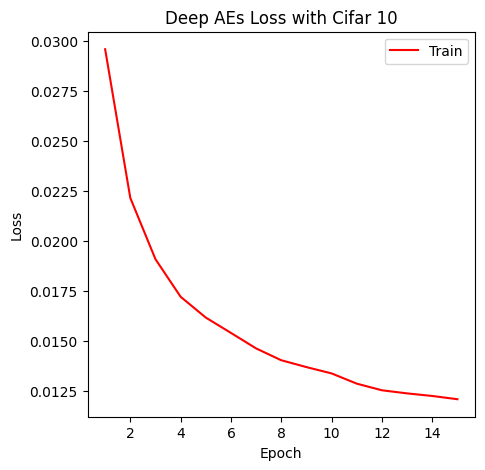

In [21]:
# Cifar 10
deep_loss_hist = []
for epoch in range(num_epochs_):
    model.train()
    train_loss = 0.0
    for images, _ in train_loader:
        images = images.to(dev)
        optimizer.zero_grad()
        outputs = model(images)
        flat_images = images.view(images.size(0), -1)
        loss = criterion(outputs, flat_images)
        with torch.no_grad():
          train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()        
    train_loss /= len(train_loader)    
    print(f"Epoch [{epoch+1}/{num_epochs_}], Loss: {train_loss:.4f}")
    deep_loss_hist.append(train_loss)

plt.figure(figsize=(5, 5))
plt.plot(range(1,num_epochs_+1), deep_loss_hist, label='Train', color='red')
plt.title('Deep AEs Loss with Cifar 10')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Epoch [1/15], Loss: 0.0296
Epoch [2/15], Loss: 0.0218
Epoch [3/15], Loss: 0.0193
Epoch [4/15], Loss: 0.0171
Epoch [5/15], Loss: 0.0162
Epoch [6/15], Loss: 0.0154
Epoch [7/15], Loss: 0.0148
Epoch [8/15], Loss: 0.0142
Epoch [9/15], Loss: 0.0135
Epoch [10/15], Loss: 0.0131
Epoch [11/15], Loss: 0.0129
Epoch [12/15], Loss: 0.0125
Epoch [13/15], Loss: 0.0123
Epoch [14/15], Loss: 0.0122
Epoch [15/15], Loss: 0.0120


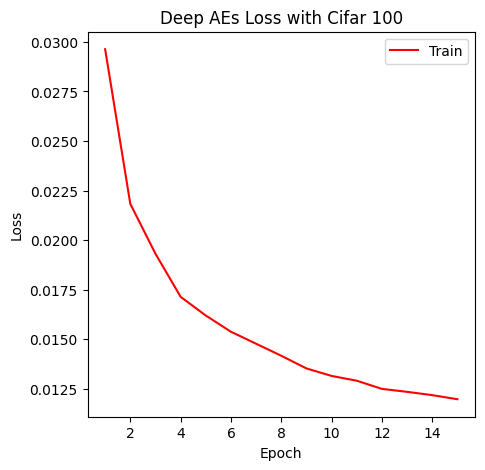

In [22]:
# Cifar 100
deep_loss_hist2 = []
for epoch in range(num_epochs_):
    model2.train()
    train_loss = 0.0
    for images, _ in train_loader:
        images = images.to(dev)
        optimizer2.zero_grad()
        outputs = model2(images)
        flat_images = images.view(images.size(0), -1)
        loss2 = criterion2(outputs, flat_images)
        with torch.no_grad():
          train_loss += loss2.item()
        optimizer2.zero_grad()
        loss2.backward()
        optimizer2.step()        
    train_loss /= len(train_loader)    
    print(f"Epoch [{epoch+1}/{num_epochs_}], Loss: {train_loss:.4f}")
    deep_loss_hist2.append(train_loss)

plt.figure(figsize=(5, 5))
plt.plot(range(1,num_epochs_+1), deep_loss_hist2, label='Train', color='red')
plt.title('Deep AEs Loss with Cifar 100')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

<Figure size 1600x1200 with 0 Axes>

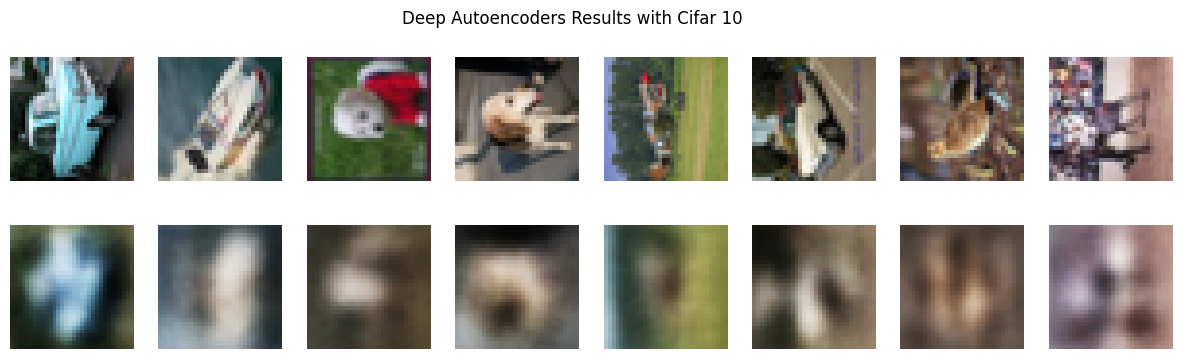

In [23]:
# Cifar 10
with torch.no_grad():
    for data_a, _ in test_loader:
        data_a = data_a.to(dev)
        recon = model(data_a)
        break
recon1 = recon.view(batch_size_, 3, 32, 32)

plt.figure(dpi=250)
fig, ax = plt.subplots(2, 8, figsize=(15, 4))
fig.suptitle('Deep Autoencoders Results with Cifar 10')
for i in range(8):
    ax[0, i].imshow(data_a[i].cpu().numpy().T)
    ax[1, i].imshow(recon1[i].cpu().numpy().T)
    ax[0, i].axis('OFF')
    ax[1, i].axis('OFF')
plt.show()

<Figure size 1600x1200 with 0 Axes>

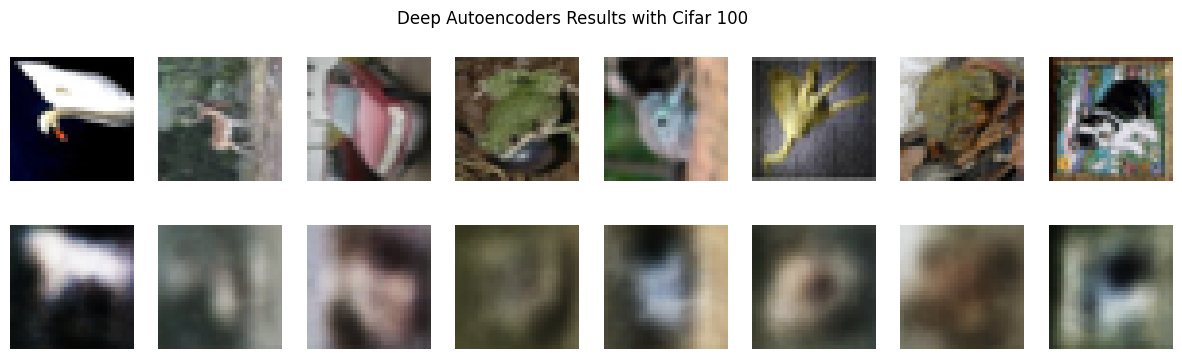

In [24]:
# Cifar 100
with torch.no_grad():
    for data_a, _ in test_loader2:
        data_a = data_a.to(dev)
        recon = model2(data_a)
        break
recon1 = recon.view(batch_size_, 3, 32, 32)

plt.figure(dpi=250)
fig, ax = plt.subplots(2, 8, figsize=(15, 4))
fig.suptitle('Deep Autoencoders Results with Cifar 100')
for i in range(8):
    ax[0, i].imshow(data_a[i].cpu().numpy().T)
    ax[1, i].imshow(recon1[i].cpu().numpy().T)
    ax[0, i].axis('OFF')
    ax[1, i].axis('OFF')
plt.show()

## 3. Sparse Autoencoders

In [25]:
# Additional hyperparameters
Gridbeta = {'beta': [0.01, 0.05, 0.1, 0.2]}

In [26]:
# Cifar 10
sparse_model = Autoencoder(input_dimension_, laten_dimension_, encoder_neurons_, decoder_neurons_)
sparse_model.to(dev)

# Cifar 100
sparse_model2 = Autoencoder(input_dimension_, laten_dimension_, encoder_neurons_, decoder_neurons_)
sparse_model2.to(dev)

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=3072, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=1024, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=3072, bias=True)
    (5): Sigmoid()
  )
)

In [27]:
# Cifar 10
sparse_criterion = nn.MSELoss()
sparse_optimizer = torch.optim.Adam(sparse_model.parameters(),
                                    lr=learning_rate_,
                                    betas=(0.9, 0.999),
                                    eps=1e-08,
                                    weight_decay=0,
                                    amsgrad=False)

# Cifar 100
sparse_criterion2 = nn.MSELoss()
sparse_optimizer2 = torch.optim.Adam(sparse_model2.parameters(),
                                    lr=learning_rate_,
                                    betas=(0.9, 0.999),
                                    eps=1e-08,
                                    weight_decay=0,
                                    amsgrad=False)

In [28]:
# General trainning
def sparse_training(model_, beta):
  for epoch in range(num_epochs_):
      model_.train()
      train_loss = 0.0
      for images, _ in train_loader:
          images = images.to(dev)
          sparse_optimizer.zero_grad()
          outputs = model_(images)
          flat_images = images.view(images.size(0), -1)
          rho_ = torch.mean(model_.latent_).cpu().item()
          sparse_penalty = beta*kl_div(0.05,rho_)
          loss = sparse_criterion(outputs,flat_images) + sparse_penalty
          with torch.no_grad():
            train_loss += loss.item()
          sparse_optimizer.zero_grad()
          loss.backward()
          sparse_optimizer.step()        
      train_loss /= len(train_loader)    
  print("Beta: ", beta, " Done!")
  return train_loss

In [29]:
# Cifar 10 GridSearch
beta_results = []
for b in Gridbeta['beta']:
  b_result = sparse_training(sparse_model, b)
  beta_results.append(b_result)

beta_results = np.array(beta_results)
best_b = np.argmin(beta_results)
beta = Gridbeta['beta'][best_b]

Stopping since train_loss has not improved in the last 10 epochs.
Beta:  0.01  Done!
Beta:  0.05  Done!
Beta:  0.1  Done!
Beta:  0.2  Done!


In [30]:
# Cifar 100 GridSearch
beta_results2 = []
for b in Gridbeta['beta']:
  b_result = sparse_training(sparse_model2, b)
  beta_results2.append(b_result)

beta_results2 = np.array(beta_results2)
best_b2 = np.argmin(beta_results2)
beta2 = Gridbeta['beta'][best_b2]

Beta:  0.01  Done!
Beta:  0.05  Done!
Beta:  0.1  Done!
Beta:  0.2  Done!


In [31]:
# Cifar 10 training
for epoch in range(num_epochs_):
    sparse_model.train()
    train_loss = 0.0
    for images, _ in train_loader:
        images = images.to(dev)
        sparse_optimizer.zero_grad()
        outputs = sparse_model(images)
        flat_images = images.view(images.size(0), -1)
        rho_ = torch.mean(sparse_model.latent_).cpu().item()
        sparse_penalty = beta*kl_div(0.05,rho_)
        loss = sparse_criterion(outputs,flat_images) + sparse_penalty
        with torch.no_grad():
          train_loss += loss.item()
        sparse_optimizer.zero_grad()
        loss.backward()
        sparse_optimizer.step()        
    train_loss /= len(train_loader)    
    print(f"Epoch [{epoch+1}/{num_epochs_}], Loss: {train_loss:.4f}")

Epoch [1/15], Loss: 0.0107
Epoch [2/15], Loss: 0.0107
Epoch [3/15], Loss: 0.0107
Epoch [4/15], Loss: 0.0107
Epoch [5/15], Loss: 0.0107
Epoch [6/15], Loss: 0.0106
Epoch [7/15], Loss: 0.0106
Epoch [8/15], Loss: 0.0106
Epoch [9/15], Loss: 0.0106
Epoch [10/15], Loss: 0.0106
Epoch [11/15], Loss: 0.0106
Epoch [12/15], Loss: 0.0106
Epoch [13/15], Loss: 0.0105
Epoch [14/15], Loss: 0.0105
Epoch [15/15], Loss: 0.0105


In [32]:
# Cifar 100 training
for epoch in range(num_epochs_):
    sparse_model2.train()
    train_loss = 0.0
    for images, _ in train_loader:
        images = images.to(dev)
        sparse_optimizer2.zero_grad()
        outputs = sparse_model2(images)
        flat_images = images.view(images.size(0), -1)
        rho_ = torch.mean(sparse_model2.latent_).cpu().item()
        sparse_penalty = beta2*kl_div(0.05,rho_)
        loss2 = sparse_criterion2(outputs,flat_images) + sparse_penalty
        with torch.no_grad():
          train_loss += loss2.item()
        sparse_optimizer2.zero_grad()
        loss2.backward()
        sparse_optimizer2.step()        
    train_loss /= len(train_loader)    
    print(f"Epoch [{epoch+1}/{num_epochs_}], Loss: {train_loss:.4f}")

Epoch [1/15], Loss: 0.0302
Epoch [2/15], Loss: 0.0227
Epoch [3/15], Loss: 0.0199
Epoch [4/15], Loss: 0.0178
Epoch [5/15], Loss: 0.0168
Epoch [6/15], Loss: 0.0162
Epoch [7/15], Loss: 0.0157
Epoch [8/15], Loss: 0.0152
Epoch [9/15], Loss: 0.0147
Epoch [10/15], Loss: 0.0145
Epoch [11/15], Loss: 0.0143
Epoch [12/15], Loss: 0.0141
Epoch [13/15], Loss: 0.0137
Epoch [14/15], Loss: 0.0135
Epoch [15/15], Loss: 0.0134


<Figure size 1600x1200 with 0 Axes>

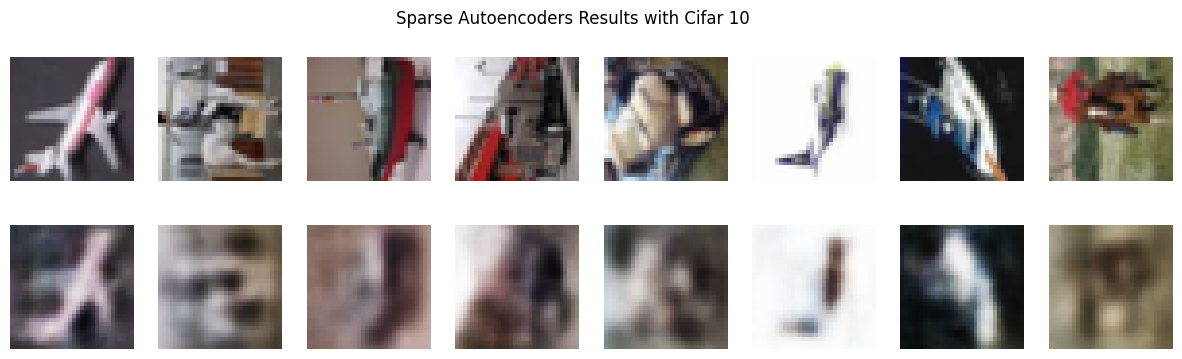

In [33]:
# Cifar 10
with torch.no_grad():
    for data_b, _ in test_loader:
        data_b = data_b.to(dev)
        sparse_recon = sparse_model(data_b)
        break
sparse_recon1 = sparse_recon.view(batch_size_, 3, 32, 32)

plt.figure(dpi=250)
fig, ax = plt.subplots(2, 8, figsize=(15, 4))
fig.suptitle('Sparse Autoencoders Results with Cifar 10')
for i in range(8):
    ax[0, i].imshow(data_b[i].cpu().numpy().T)
    ax[1, i].imshow(sparse_recon1[i].cpu().numpy().T)
    ax[0, i].axis('OFF')
    ax[1, i].axis('OFF')
plt.show()

<Figure size 1600x1200 with 0 Axes>

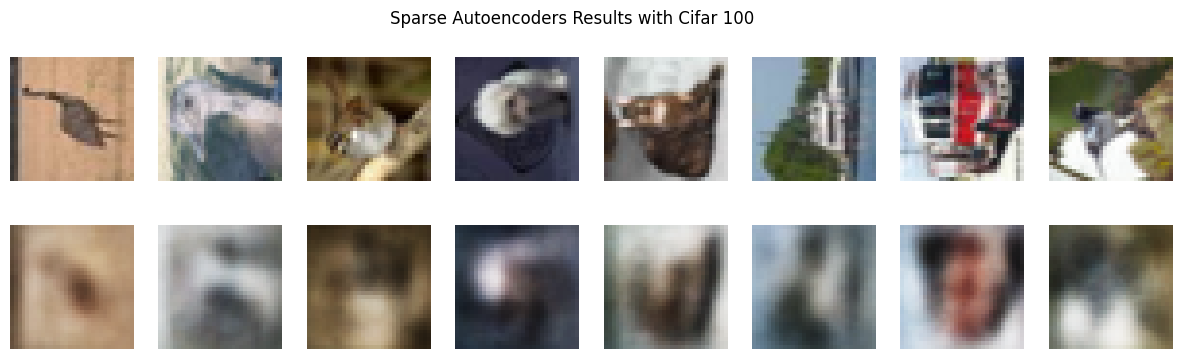

In [34]:
# Cifar 100
with torch.no_grad():
    for data_b, _ in test_loader2:
        data_b = data_b.to(dev)
        sparse_recon = sparse_model2(data_b)
        break
sparse_recon1 = sparse_recon.view(batch_size_, 3, 32, 32)

plt.figure(dpi=250)
fig, ax = plt.subplots(2, 8, figsize=(15, 4))
fig.suptitle('Sparse Autoencoders Results with Cifar 100')
for i in range(8):
    ax[0, i].imshow(data_b[i].cpu().numpy().T)
    ax[1, i].imshow(sparse_recon1[i].cpu().numpy().T)
    ax[0, i].axis('OFF')
    ax[1, i].axis('OFF')
plt.show()

## 4. Denoising Autoencoders

In [35]:
# Cifar 10
denoising_model = Autoencoder(input_dimension_, laten_dimension_, encoder_neurons_, decoder_neurons_)
denoising_model.to(dev)

# Cifar 100
denoising_model2 = Autoencoder(input_dimension_, laten_dimension_, encoder_neurons_, decoder_neurons_)
denoising_model2.to(dev)

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=3072, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=1024, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=3072, bias=True)
    (5): Sigmoid()
  )
)

In [36]:
# Cifar 10
denoising_criterion = nn.MSELoss()
denoising_optimizer = torch.optim.Adam(denoising_model.parameters(),
                                       lr=learning_rate_,
                                       betas=(0.9, 0.999),
                                       eps=1e-08,
                                       weight_decay=0,
                                       amsgrad=False)

# Cifar 100
denoising_criterion2 = nn.MSELoss()
denoising_optimizer2 = torch.optim.Adam(denoising_model.parameters(),
                                       lr=learning_rate_,
                                       betas=(0.9, 0.999),
                                       eps=1e-08,
                                       weight_decay=0,
                                       amsgrad=False)

Epoch [1/15], Loss: 0.0384
Epoch [2/15], Loss: 0.0304
Epoch [3/15], Loss: 0.0280
Epoch [4/15], Loss: 0.0257
Epoch [5/15], Loss: 0.0247
Epoch [6/15], Loss: 0.0239
Epoch [7/15], Loss: 0.0233
Epoch [8/15], Loss: 0.0228
Epoch [9/15], Loss: 0.0221
Epoch [10/15], Loss: 0.0218
Epoch [11/15], Loss: 0.0217
Epoch [12/15], Loss: 0.0213
Epoch [13/15], Loss: 0.0211
Epoch [14/15], Loss: 0.0209
Epoch [15/15], Loss: 0.0207


<Figure size 1600x1200 with 0 Axes>

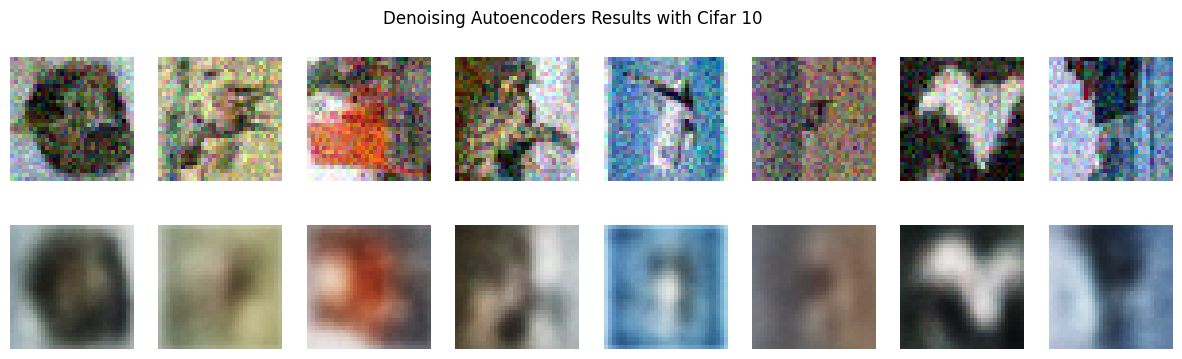

In [37]:
# Cifar 10
noise = 0.1
for epoch in range(num_epochs_):
    denoising_model.train()
    train_loss = 0.0
    for images, _ in train_loader:
        images_noisy = images + noise * torch.randn(images.shape)
        images_noisy = np.clip(images_noisy, 0., 1.)
        images_noisy = images_noisy.to(dev)
        denoising_optimizer.zero_grad()
        outputs = denoising_model(images_noisy)
        flat_images = images_noisy.view(images_noisy.size(0), -1)
        loss = denoising_criterion(outputs,flat_images)
        with torch.no_grad():
          train_loss += loss.item()
        denoising_optimizer.zero_grad()
        loss.backward()
        denoising_optimizer.step()        
    train_loss /= len(train_loader)    
    print(f"Epoch [{epoch+1}/{num_epochs_}], Loss: {train_loss:.4f}")

with torch.no_grad():
    for data_c, _ in test_loader:
        data_c = data_c + noise * torch.randn(data_c.shape)
        data_c = np.clip(data_c, 0., 1.)
        data_c = data_c.to(dev)
        denoising_recon = denoising_model(data_c)
        break
denoising_recon1 = denoising_recon.view(batch_size_, 3, 32, 32)

plt.figure(dpi=250)
fig, ax = plt.subplots(2, 8, figsize=(15, 4))
fig.suptitle('Denoising Autoencoders Results with Cifar 10')
for i in range(8):
    ax[0, i].imshow(data_c[i].cpu().numpy().T)
    ax[1, i].imshow(denoising_recon1[i].cpu().numpy().T)
    ax[0, i].axis('OFF')
    ax[1, i].axis('OFF')
plt.show()

Epoch [1/15], Loss: 0.0304
Epoch [2/15], Loss: 0.0302
Epoch [3/15], Loss: 0.0301
Epoch [4/15], Loss: 0.0300
Epoch [5/15], Loss: 0.0299
Epoch [6/15], Loss: 0.0297
Epoch [7/15], Loss: 0.0296
Epoch [8/15], Loss: 0.0294
Epoch [9/15], Loss: 0.0293
Epoch [10/15], Loss: 0.0292
Epoch [11/15], Loss: 0.0291
Epoch [12/15], Loss: 0.0291
Epoch [13/15], Loss: 0.0290
Epoch [14/15], Loss: 0.0289
Epoch [15/15], Loss: 0.0288


<Figure size 1600x1200 with 0 Axes>

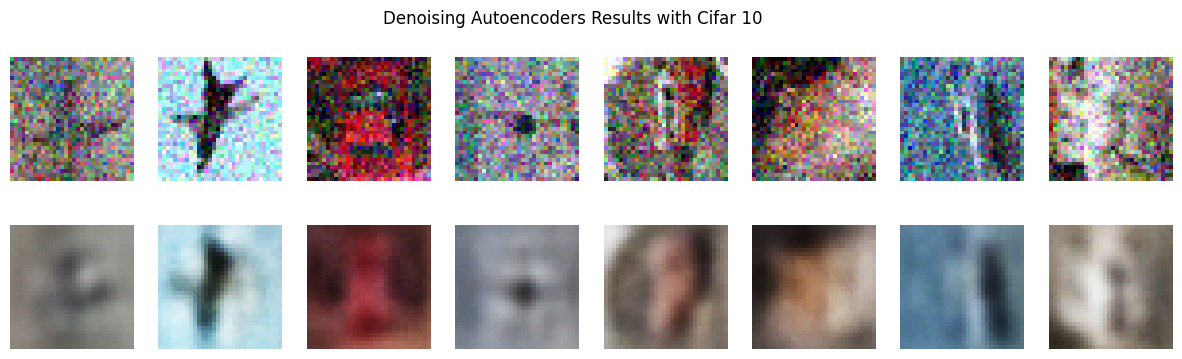

In [38]:
# Cifar 10
noise = 0.15
for epoch in range(num_epochs_):
    denoising_model.train()
    train_loss = 0.0
    for images, _ in train_loader:
        images_noisy = images + noise * torch.randn(images.shape)
        images_noisy = np.clip(images_noisy, 0., 1.)
        images_noisy = images_noisy.to(dev)
        denoising_optimizer.zero_grad()
        outputs = denoising_model(images_noisy)
        flat_images = images_noisy.view(images_noisy.size(0), -1)
        loss = denoising_criterion(outputs,flat_images)
        with torch.no_grad():
          train_loss += loss.item()
        denoising_optimizer.zero_grad()
        loss.backward()
        denoising_optimizer.step()        
    train_loss /= len(train_loader)    
    print(f"Epoch [{epoch+1}/{num_epochs_}], Loss: {train_loss:.4f}")

with torch.no_grad():
    for data_c, _ in test_loader:
        data_c = data_c + noise * torch.randn(data_c.shape)
        data_c = np.clip(data_c, 0., 1.)
        data_c = data_c.to(dev)
        denoising_recon = denoising_model(data_c)
        break
denoising_recon1 = denoising_recon.view(batch_size_, 3, 32, 32)

plt.figure(dpi=250)
fig, ax = plt.subplots(2, 8, figsize=(15, 4))
fig.suptitle('Denoising Autoencoders Results with Cifar 10')
for i in range(8):
    ax[0, i].imshow(data_c[i].cpu().numpy().T)
    ax[1, i].imshow(denoising_recon1[i].cpu().numpy().T)
    ax[0, i].axis('OFF')
    ax[1, i].axis('OFF')
plt.show()

Epoch [1/15], Loss: 0.1057
Epoch [2/15], Loss: 0.1057
Epoch [3/15], Loss: 0.1057
Epoch [4/15], Loss: 0.1057
Epoch [5/15], Loss: 0.1057
Epoch [6/15], Loss: 0.1057
Epoch [7/15], Loss: 0.1057
Epoch [8/15], Loss: 0.1057
Epoch [9/15], Loss: 0.1057
Epoch [10/15], Loss: 0.1057
Epoch [11/15], Loss: 0.1057
Epoch [12/15], Loss: 0.1057
Epoch [13/15], Loss: 0.1057
Epoch [14/15], Loss: 0.1057
Epoch [15/15], Loss: 0.1057


<Figure size 1600x1200 with 0 Axes>

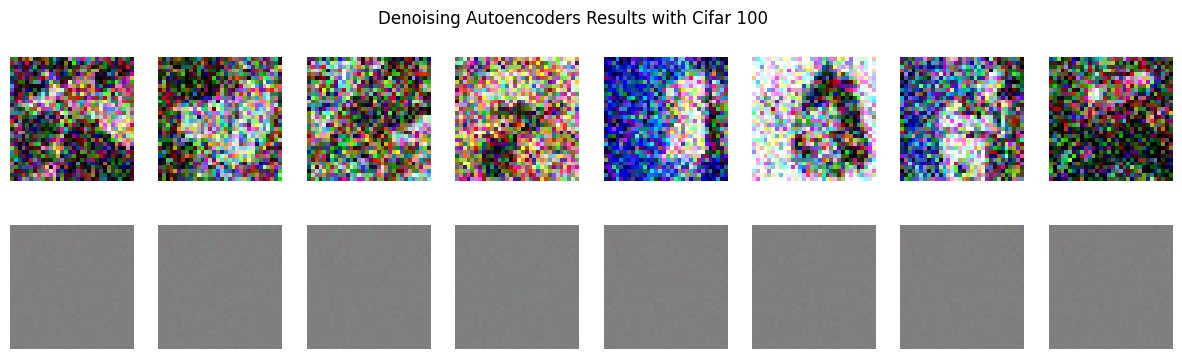

In [39]:
# Cifar 100
noise = 0.3
for epoch in range(num_epochs_):
    denoising_model2.train()
    train_loss = 0.0
    for images, _ in train_loader:
        images_noisy = images + noise * torch.randn(images.shape)
        images_noisy = np.clip(images_noisy, 0., 1.)
        images_noisy = images_noisy.to(dev)
        denoising_optimizer2.zero_grad()
        outputs = denoising_model2(images_noisy)
        flat_images = images_noisy.view(images_noisy.size(0), -1)
        loss2 = denoising_criterion2(outputs,flat_images)
        with torch.no_grad():
          train_loss += loss2.item()
        denoising_optimizer2.zero_grad()
        loss2.backward()
        denoising_optimizer2.step()        
    train_loss /= len(train_loader)    
    print(f"Epoch [{epoch+1}/{num_epochs_}], Loss: {train_loss:.4f}")

with torch.no_grad():
    for data_c, _ in test_loader2:
        data_c = data_c + noise * torch.randn(data_c.shape)
        data_c = np.clip(data_c, 0., 1.)
        data_c = data_c.to(dev)
        denoising_recon = denoising_model2(data_c)
        break
denoising_recon1 = denoising_recon.view(batch_size_, 3, 32, 32)

plt.figure(dpi=250)
fig, ax = plt.subplots(2, 8, figsize=(15, 4))
fig.suptitle('Denoising Autoencoders Results with Cifar 100')
for i in range(8):
    ax[0, i].imshow(data_c[i].cpu().numpy().T)
    ax[1, i].imshow(denoising_recon1[i].cpu().numpy().T)
    ax[0, i].axis('OFF')
    ax[1, i].axis('OFF')
plt.show()

Epoch [1/15], Loss: 0.1405
Epoch [2/15], Loss: 0.1405
Epoch [3/15], Loss: 0.1405
Epoch [4/15], Loss: 0.1405
Epoch [5/15], Loss: 0.1405
Epoch [6/15], Loss: 0.1405
Epoch [7/15], Loss: 0.1405
Epoch [8/15], Loss: 0.1405
Epoch [9/15], Loss: 0.1405
Epoch [10/15], Loss: 0.1405
Epoch [11/15], Loss: 0.1405
Epoch [12/15], Loss: 0.1405
Epoch [13/15], Loss: 0.1405
Epoch [14/15], Loss: 0.1405
Epoch [15/15], Loss: 0.1405


<Figure size 1600x1200 with 0 Axes>

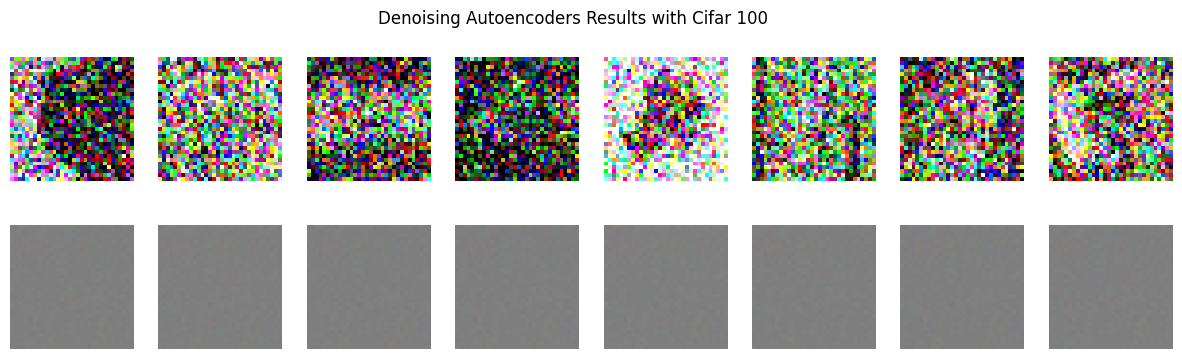

In [40]:
# Cifar 100
noise = 0.5
for epoch in range(num_epochs_):
    denoising_model2.train()
    train_loss = 0.0
    for images, _ in train_loader:
        images_noisy = images + noise * torch.randn(images.shape)
        images_noisy = np.clip(images_noisy, 0., 1.)
        images_noisy = images_noisy.to(dev)
        denoising_optimizer2.zero_grad()
        outputs = denoising_model2(images_noisy)
        flat_images = images_noisy.view(images_noisy.size(0), -1)
        loss2 = denoising_criterion2(outputs,flat_images)
        with torch.no_grad():
          train_loss += loss2.item()
        denoising_optimizer2.zero_grad()
        loss2.backward()
        denoising_optimizer2.step()        
    train_loss /= len(train_loader)    
    print(f"Epoch [{epoch+1}/{num_epochs_}], Loss: {train_loss:.4f}")

with torch.no_grad():
    for data_c, _ in test_loader2:
        data_c = data_c + noise * torch.randn(data_c.shape)
        data_c = np.clip(data_c, 0., 1.)
        data_c = data_c.to(dev)
        denoising_recon = denoising_model2(data_c)
        break
denoising_recon1 = denoising_recon.view(batch_size_, 3, 32, 32)

plt.figure(dpi=250)
fig, ax = plt.subplots(2, 8, figsize=(15, 4))
fig.suptitle('Denoising Autoencoders Results with Cifar 100')
for i in range(8):
    ax[0, i].imshow(data_c[i].cpu().numpy().T)
    ax[1, i].imshow(denoising_recon1[i].cpu().numpy().T)
    ax[0, i].axis('OFF')
    ax[1, i].axis('OFF')
plt.show()

## 5. Anomaly Detection

In [41]:
# Additional hyperparameters
anomaly_sample = 7

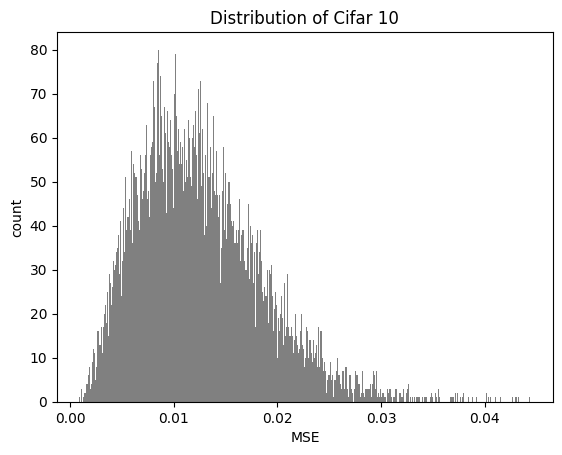

In [42]:
# Cifar 10
all_images = []
anomaly_loss = []
feature_images = []
target_images = []
with torch.no_grad():
    for anomaly_images, _ in test_loader:
        anomaly_images = anomaly_images.to(dev)
        anomaly_recon = model(anomaly_images)
        anomaly_flat_images = anomaly_images.view(anomaly_images.size(0), -1)
        batch_size = anomaly_recon.shape[0]
        for i_batch in range(batch_size):
          i_loss = criterion(anomaly_recon[i_batch],anomaly_flat_images[i_batch]).cpu()
          anomaly_loss.append(i_loss.numpy())
          feature_images.append(anomaly_images[i_batch])
          target_images.append(anomaly_recon[i_batch].view(3, 32, 32))
anomaly_loss = np.array(anomaly_loss)

plt.hist(anomaly_loss, bins=500, color='grey')
plt.title('Distribution of Cifar 10')
plt.xlabel("MSE")
plt.ylabel("count")
plt.show()

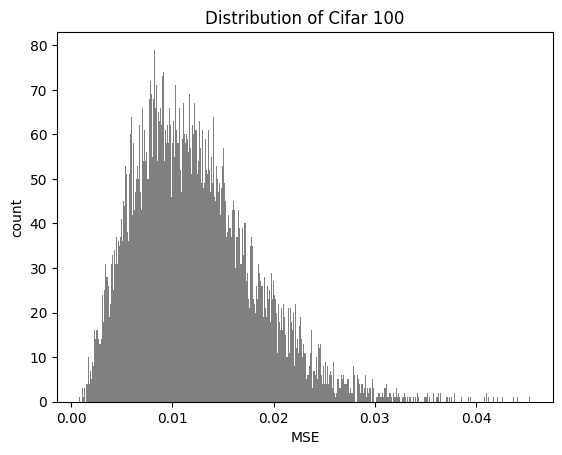

In [43]:
# Cifar 100
all_images = []
anomaly_loss = []
feature_images2 = []
target_images2 = []
with torch.no_grad():
    for anomaly_images, _ in test_loader2:
        anomaly_images = anomaly_images.to(dev)
        anomaly_recon = model2(anomaly_images)
        anomaly_flat_images = anomaly_images.view(anomaly_images.size(0), -1)
        batch_size = anomaly_recon.shape[0]
        for i_batch in range(batch_size):
          i_loss = criterion2(anomaly_recon[i_batch],anomaly_flat_images[i_batch]).cpu()
          anomaly_loss.append(i_loss.numpy())
          feature_images2.append(anomaly_images[i_batch])
          target_images2.append(anomaly_recon[i_batch].view(3, 32, 32))
anomaly_loss2 = np.array(anomaly_loss)

plt.hist(anomaly_loss2, bins=500, color='grey')
plt.title('Distribution of Cifar 100')
plt.xlabel("MSE")
plt.ylabel("count")
plt.show()

<Figure size 1600x1200 with 0 Axes>

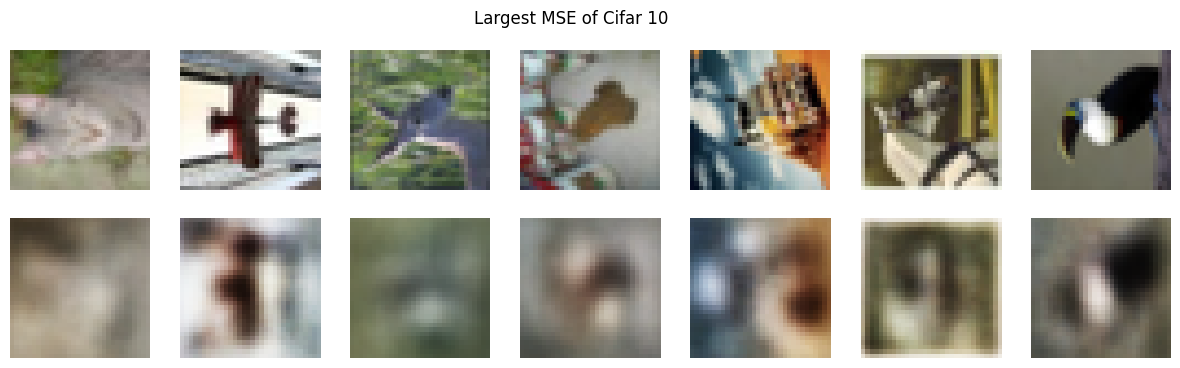

In [44]:
# Cifar 10
anomalies_indx = np.argsort(anomaly_loss)[-anomaly_sample:]
plt.figure(dpi=250)
fig, ax = plt.subplots(2, anomaly_sample, figsize=(15, 4))
fig.suptitle('Largest MSE of Cifar 10')
for i in range(anomaly_sample):
    ax[0, i].imshow(feature_images[anomalies_indx[i]].cpu().numpy().T)
    ax[1, i].imshow(target_images[anomalies_indx[i]].cpu().numpy().T)
    ax[0, i].axis('OFF')
    ax[1, i].axis('OFF')
plt.show()

<Figure size 1600x1200 with 0 Axes>

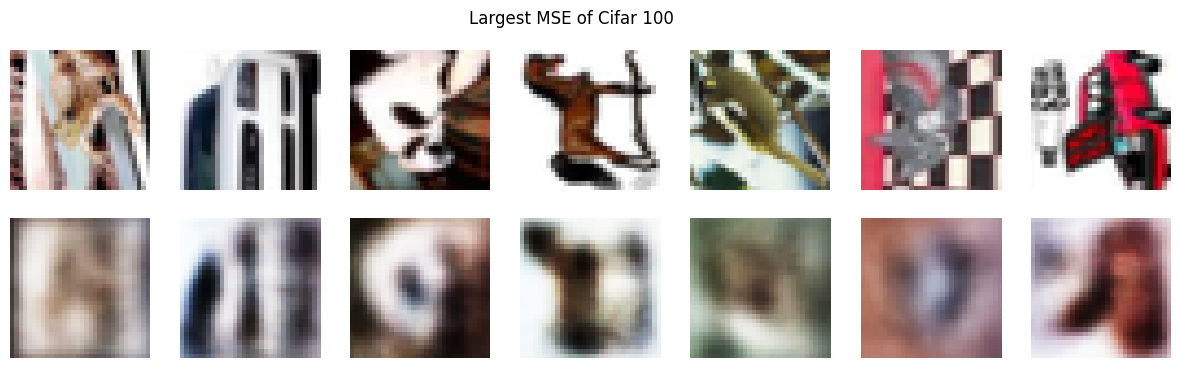

In [45]:
# Cifar 100
anomalies_indx = np.argsort(anomaly_loss2)[-anomaly_sample:]
plt.figure(dpi=250)
fig, ax = plt.subplots(2, anomaly_sample, figsize=(15, 4))
fig.suptitle('Largest MSE of Cifar 100')
for i in range(anomaly_sample):
    ax[0, i].imshow(feature_images2[anomalies_indx[i]].cpu().numpy().T)
    ax[1, i].imshow(target_images2[anomalies_indx[i]].cpu().numpy().T)
    ax[0, i].axis('OFF')
    ax[1, i].axis('OFF')
plt.show()